In [38]:
import pandas as pd
import sqlalchemy
import math
import os, sys, copy, random, pickle, cv2
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

sys.path.append("../")

%load_ext autoreload
%autoreload 2

from modules.ControlTracking import TrackFactory
from modules.ControlDisplay import Display
from modules.Interproc import DBInterface, GuiviewState

from modules.AnalysisHelpers import ( 
         exploreImgs, buildImgComparisonData, subprocEval,
        subprocBatchOutput, cvtPlot)

from modules.EvalHelpers import EvalTracker, EvalDataset
from modules.ControlEval import EvalFactory
from modules.DataSchemas import ScoreSchema
from modules.EvalHelpers import OutcomeData, DFHelper

from modules.EvalHelpers import AggEval, DFHelper

from modules.EvalSuite import EvalSuite, CmpAlgoReport

from IPython.display import display

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
#Load outcome data, pre-eval'd via command-line and saved to book-data

db_path = 'data/misc/books/eval_report_2/'

outcome_0 = OutcomeData(dbPathFn = db_path + 'algo_0.db')
outcome_2 = OutcomeData(dbPathFn = db_path + 'algo_2.db')

In [10]:
cmpA = CmpAlgoReport(benchmark_outcome_data = outcome_0.getOutcome(), 
                     current_outcome_data = outcome_2.getOutcome()
                    )

,improvements,deprovements,sames
checkTrackSuccess,0.000,0.000,345.000


,improvements,deprovements,sames
calcBaselineBallUnitsAway,7,3,9
checkBothContainsOther,3,0,16
checkTrackSuccess,0,0,19
distanceFromBaseline,7,3,9


,diff,current,benchmark
,mean,mean,mean
agg_checkTrackSuccess,0.000,1.000,1.000
agg_calcBaselineBallUnitsAway,0.053,-0.407,-0.460
agg_checkBothContainsOther,0.158,0.579,0.421
agg_distanceFromBaseline,0.366,-5.125,-5.491


diff        current          benchmark  \
                                   mean      n    mean        n      mean   
fagg_less_than_20_pix_balls_away  0.066  0.000  -0.467   16.000    -0.533   
fagg_less_than_30_pix_success     0.000  0.000   1.000  310.000     1.000   

                                           
                                        n  
fagg_less_than_20_pix_balls_away   16.000  
fagg_less_than_30_pix_success     310.000

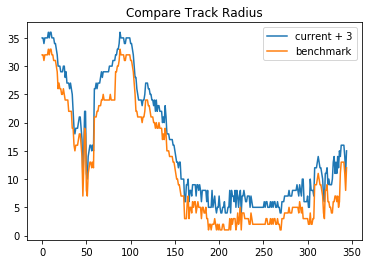

In [11]:
cmpA.report1()

In [15]:
ret = cmpA.largestDiscrepancy(distanceFromBaseline=0)
display(ret[:6])
foi = [int(x) for x in ret.index]
print foi[:5]

,diff,current,benchmark
,distanceFromBaseline,distanceFromBaseline,distanceFromBaseline
295,4.434,-5.000,-9.434
78,-2.828,-4.243,-1.414
215,2.385,-3.000,-5.385
187,1.143,-4.243,-5.385
195,1.000,-3.000,-4.000
307,0.630,-10.000,-10.630


[295, 78, 215, 187, 195]


In [16]:
ret = cmpA.largestDiscrepancy(calcBaselineBallUnitsAway=0)
display(ret[:6])
foi = [int(x) for x in ret.index]
print foi[:5]

,diff,current,benchmark
,calcBaselineBallUnitsAway,calcBaselineBallUnitsAway,calcBaselineBallUnitsAway
295,0.443,-0.500,-0.943
215,0.298,-0.375,-0.673
187,0.143,-0.530,-0.673
195,0.125,-0.375,-0.500
78,-0.057,-0.085,-0.028
307,0.045,-0.714,-0.759


[295, 215, 187, 195, 78]


### View Discrepancy Images

In [39]:
vid_fn = 'data/proc/tmp/dec14/output5.proc1.proc1.avi'
listGS = subprocBatchOutput(vid_fn, batch_list = foi[:6])

In [40]:
print 'orginal order: '
print [gs.frameCounter for gs in listGS]

# order by discrepancy table
def discrepancyLookup(frame_counter):
    try:
        return foi.index(frame_counter)
    except:
        return 0

listGS.sort(key=lambda item: discrepancyLookup(item.frameCounter), reverse = True)

print 'new order: '
print [gs.frameCounter for gs in listGS]

orginal order: 
[78, 187, 195, 215, 295, 307]
new order: 
[307, 78, 195, 187, 215, 295]


In [37]:
# get this working
exploreImgs(listGS)

AttributeError: 'NoneType' object has no attribute 'copy'

In [47]:
gs = listGS[1]

In [49]:
gs.initDisplay()

307


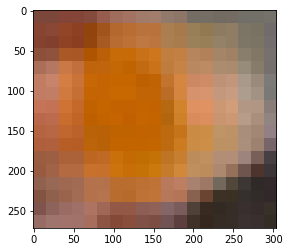

78


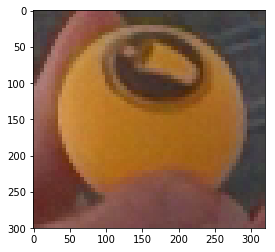

195


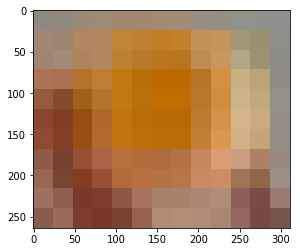

187


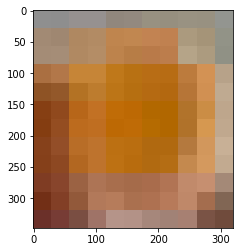

215


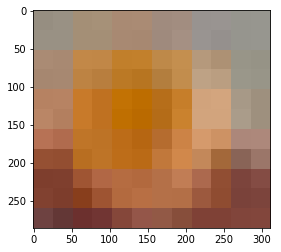

295


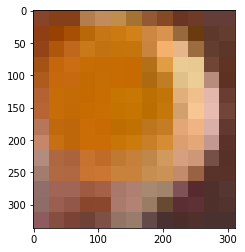

In [52]:
for _gs in listGS:
    print _gs.frameCounter
    _gs.initDisplay()
    cvtPlot(_gs.display.scoreFrame)
    plt.show()

In [48]:
cvtPlot(gs.display.scoreFrame)

AttributeError: GuiviewState instance has no attribute 'display'